# Udacity Deep Learning Project - Digit Recognition - Part 1

Author: Lei Mao <br>
Late revised on: 12/23/2016 <br>

## multiMNIST Continuous Dataset Preparation

### Import libraries quired

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import sys
import tarfile
import gzip
import struct
from scipy import ndimage
from sklearn.model_selection import train_test_split
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
%autosave 0

Autosave disabled


### Download MNIST dataset

Download MNIST dataset from http://yann.lecun.com/exdb/mnist/

In [3]:
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for users with
    slow internet connections. Reports every 1% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)
    
    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()
            
        last_percent_reported = percent

def maybe_download(filename, expected_bytes, url, destination_folder, force = False):
    """Download a file if not present, and make sure it's the right size."""
    filename_real = destination_folder + filename
    if force or not os.path.exists(filename_real):
        if not os.path.exists(destination_folder):
            os.makedirs(destination_folder)
        print('Attempting to download:', filename) 
        filename_real, _ = urlretrieve(url + filename, filename_real, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(filename_real)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        raise Exception('Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename_real

In [4]:
url_MNIST = 'http://yann.lecun.com/exdb/mnist/'
MNIST_folder = 'data/MNIST/'

train_image_filename = maybe_download(filename = 'train-images-idx3-ubyte.gz', expected_bytes = 9912422, 
                                      url = url_MNIST, destination_folder = MNIST_folder)
train_label_filename = maybe_download(filename = 'train-labels-idx1-ubyte.gz', expected_bytes = 28881, 
                                      url = url_MNIST, destination_folder = MNIST_folder)
test_image_filename = maybe_download(filename = 't10k-images-idx3-ubyte.gz', expected_bytes = 1648877, 
                                     url = url_MNIST, destination_folder = MNIST_folder)
test_label_filename = maybe_download(filename = 't10k-labels-idx1-ubyte.gz', expected_bytes = 4542, 
                                     url = url_MNIST, destination_folder = MNIST_folder)

('Found and verified', 'train-images-idx3-ubyte.gz')
('Found and verified', 'train-labels-idx1-ubyte.gz')
('Found and verified', 't10k-images-idx3-ubyte.gz')
('Found and verified', 't10k-labels-idx1-ubyte.gz')


### Extract MNIST dataset

In [5]:
def load_mnist_image(filename_real):
    """Load the MNIST image data"""
    with gzip.open(filename_real, 'rb') as f:
        buf = f.read()
    # Calculate the number of images in the dataset
    # Read binary data buf from index 0
    index = 0
    # '>IIII': read 4 unsigned int
    # See: https://docs.python.org/2/library/struct.html?highlight=struct.unpack#struct.unpack
    # The first 4 unsigned int are variables magic, numImages , numRows , numColumns
    magic, numImages, numRows, numColumns = struct.unpack_from('>IIII' , buf , index)
    print('Loading MNIST dataset: %s' %filename_real.split('/')[-1])
    print('Number of images: %d, Image size: %d * %d' %(numImages, numRows, numColumns))
    # In MNIST dataset, numRows = 28, numColumns = 28
    # Move index cursor
    index += struct.calcsize('>IIII')
    # Start to read image data and store the image data to ndarray
    # '>784B': read 784 (28*28) unsigned int
    binary_format = '>' + str(numRows * numColumns) + 'B'
    dataset = np.ndarray(shape=(numImages, numRows, numColumns), dtype=np.uint8)
    for i in xrange(numImages):
        im = struct.unpack_from(binary_format ,buf, index)
        index += struct.calcsize(binary_format)
        im = np.array(im)
        im = im.reshape(numRows, numRows)
        dataset[i] = im
    return dataset

In [6]:
def load_mnist_label(filename_real):
    """Load the MNIST label data"""
    with gzip.open(filename_real, 'rb') as f:
        buf = f.read()
    index = 0
    magic, numImages = struct.unpack_from('>II' , buf , index)
    print('Loading MNIST labelset: %s' %filename_real.split('/')[-1])
    print('Number of labels: %d' %numImages)
    index += struct.calcsize('>II')
    binary_format = '>' + str(numImages) + 'B'
    label = struct.unpack_from(binary_format, buf, index)
    index += struct.calcsize(binary_format)
    label = np.array(label)
    label = label.reshape(numImages,1)
    return label

In [7]:
train_data = load_mnist_image(train_image_filename)
train_label = load_mnist_label(train_label_filename)
test_data = load_mnist_image(test_image_filename)
test_label = load_mnist_label(test_label_filename)

Loading MNIST dataset: train-images-idx3-ubyte.gz
Number of images: 60000, Image size: 28 * 28
Loading MNIST labelset: train-labels-idx1-ubyte.gz
Number of labels: 60000
Loading MNIST dataset: t10k-images-idx3-ubyte.gz
Number of images: 10000, Image size: 28 * 28
Loading MNIST labelset: t10k-labels-idx1-ubyte.gz
Number of labels: 10000


### Verify the extracted MNIST data

In [8]:
# Check if the number of images and labels are the same
if len(train_data) != len(train_label):
    print('The size of train data and train label did not match!')
else:
    print('The size of train data and train label are the same.')
if len(test_data) != len(test_label):
    print('The size of test data and test label did not match!')
else:
    print('The size of test data and test label are the same.')

The size of train data and train label are the same.
The size of test data and test label are the same.


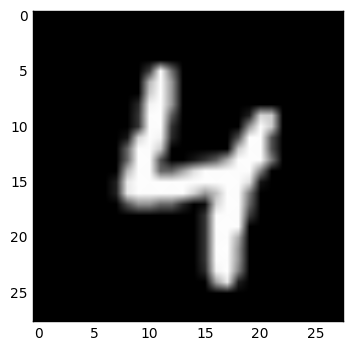

The label of this image from training set is 4


In [9]:
# Pick a random image from the training set
random_id = np.random.randint(len(train_data))
# Plot the image
fig = plt.figure()
plotwindow = fig.add_subplot(111)
plt.imshow(train_data[random_id], cmap='gray')
plt.show()
# Print the label of the image
print('The label of this image from training set is %d' %train_label[random_id])

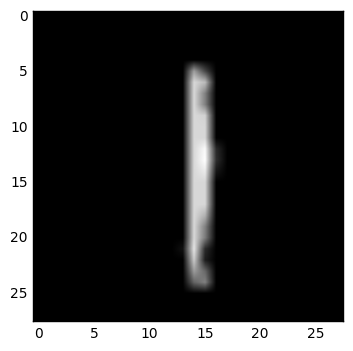

The label of this image from test set is 1


In [10]:
# Pick a random image from the test set
random_id = np.random.randint(len(test_data))
# Plot the image
fig = plt.figure()
plotwindow = fig.add_subplot(111)
plt.imshow(test_data[random_id], cmap='gray')
plt.show()
# Print the label of the image
print('The label of this image from test set is %d' %test_label[random_id])

### Save the processed data to file on hard drive

In [11]:
def maybe_pickle(dataset, set_filename, destination_folder, force = False):
    filename_real = destination_folder + set_filename + '.pickle'
    filename = set_filename + '.pickle'
    if os.path.exists(filename_real) and not force:
        print('%s already present - Skipping pickling.' %filename)
    else:
        if not os.path.exists(destination_folder):
            os.makedirs(destination_folder)
        print('Pickling %s.' %set_filename)
        try:
            with open(filename_real, 'wb') as f:
                pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            print(filename + ' saved' + ' successfully')
        except Exception as e:
            print('Unable to save data to', filename, ':', e)

In [12]:
maybe_pickle(dataset = train_data, set_filename = 'MNIST_train_data', destination_folder = MNIST_folder)
maybe_pickle(dataset = train_label, set_filename = 'MNIST_train_label', destination_folder = MNIST_folder)
maybe_pickle(dataset = test_data, set_filename = 'MNIST_test_data', destination_folder = MNIST_folder)
maybe_pickle(dataset = test_label, set_filename = 'MNIST_test_label', destination_folder = MNIST_folder)

MNIST_train_data.pickle already present - Skipping pickling.
MNIST_train_label.pickle already present - Skipping pickling.
MNIST_test_data.pickle already present - Skipping pickling.
MNIST_test_label.pickle already present - Skipping pickling.


In [13]:
# Save all the data and labels to single pickle file
pickle_file = 'MNIST.pickle'
if os.path.exists(MNIST_folder + pickle_file):
    print('%s already present - Skipping pickling.' %pickle_file)
else:
    try:
        f = open(MNIST_folder + pickle_file, 'wb')
        save = {
            'train_dataset': train_data,
            'train_labels': train_label,
            'test_dataset': test_data,
            'test_labels': test_label,
        }
        pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
        f.close()
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

MNIST.pickle already present - Skipping pickling.


### Generate synthetic sequence of digits dataset - multiMNIST_continuous

The features of this synthetic dataset:
* The length of synthetic sequence of digits is 5
* There can only be missing value in the beginning or the end of sequence
* The sequence has at least one digit
* The missing digit image is a 28 × 28 numpy array filled with zero, labeled as 99
* The 5 digits are concatenated together, resulting in a image with a size of 28 × (28 × 5)
* The synthetic dataset contains the same number of images for 1-digit, 2-digit, 3-digit, 4-digit, 5-digit sequences, respectively

In [14]:
# Read data from MNIST.pickle
pickle_file = 'MNIST.pickle'

with open(MNIST_folder + pickle_file, 'rb') as f:
    save = pickle.load(f)
    mnist_train_dataset = save['train_dataset']
    mnist_train_labels = save['train_labels']
    mnist_test_dataset = save['test_dataset']
    mnist_test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('MNIST training set', mnist_train_dataset.shape, mnist_train_labels.shape)
    print('MNIST test set', mnist_test_dataset.shape, mnist_test_labels.shape)

('MNIST training set', (60000, 28, 28), (60000, 1))
('MNIST test set', (10000, 28, 28), (10000, 1))


In [15]:
def sequence_synthesis_continuous(data, labels, size_synthesis, length_sequence):
    '''Generate synthetic digit sequence of certain size and sequence length'''
    if len(data) != len(labels):
        print('Warning: raw data and label sizes mismatch!')
        
    numRows, numColumns = data[0].shape
    blank_image = np.array([[0.] * numColumns] * numRows)
    blank_label = 10
    
    synthetic_image = np.ndarray(shape=(size_synthesis, numRows, numColumns * length_sequence), dtype=np.uint8)
    synthetic_label = np.ndarray(shape=(size_synthesis, length_sequence), dtype=np.uint8)
    
    for i in xrange(length_sequence):
        # i is the number of blanks in the sequence
        # i ranges from 0 to length_sequence - 1
        for j in xrange(size_synthesis // length_sequence):
            sequence_data = list()
            sequence_label = list()            
            for _ in xrange(length_sequence - i):
                random_id = np.random.randint(len(data))
                sequence_data.append(data[random_id])
                sequence_label.append(labels[random_id][0])
            sequence_data = np.concatenate((sequence_data), axis=1)
            for _ in xrange(i):
                # randomly put blanks at the beginning or end of the sequence
                if np.random.randint(2) == 0: # put blanks at the beginning
                    sequence_data = np.concatenate((blank_image, sequence_data), axis=1)
                    sequence_label = [blank_label] + sequence_label
                else: # put blanks at the end
                    sequence_data = np.concatenate((sequence_data, blank_image), axis=1)
                    sequence_label = sequence_label + [blank_label] 
            sequence_label = np.array(sequence_label)
            synthetic_image[i * size_synthesis // length_sequence + j] = sequence_data
            synthetic_label[i * size_synthesis // length_sequence + j] = sequence_label
    
    return synthetic_image, synthetic_label

In [16]:
size_synthesis = 80000
length_sequence = 5
multiMNIST_data, multiMNIST_labels = sequence_synthesis_continuous(
    data = mnist_train_dataset, labels = mnist_train_labels, 
    size_synthesis = size_synthesis, length_sequence = length_sequence)

In [17]:
# Prepare training, validation and test datasets and labels
multiMNIST_train_dataset, multiMNIST_test_dataset, multiMNIST_train_labels, multiMNIST_test_labels = train_test_split(
    multiMNIST_data, multiMNIST_labels, test_size = 1./10, random_state = 0)
multiMNIST_train_dataset, multiMNIST_valid_dataset, multiMNIST_train_labels, multiMNIST_valid_labels = train_test_split(
    multiMNIST_train_dataset, multiMNIST_train_labels, test_size = 1./9, random_state = 0)

In [18]:
# Check the size of each dataset
print('Training set: %d images and %d labels.' %(len(multiMNIST_train_dataset), len(multiMNIST_train_labels)))
print('Validation set: %d images and %d labels.' %(len(multiMNIST_valid_dataset), len(multiMNIST_valid_labels)))
print('Test set: %d images and %d labels.' %(len(multiMNIST_test_dataset), len(multiMNIST_test_labels)))

Training set: 64000 images and 64000 labels.
Validation set: 8000 images and 8000 labels.
Test set: 8000 images and 8000 labels.


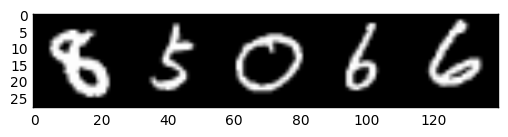

The label of this image from training set is [8 5 0 6 6]


In [19]:
# Pick a random image from the training set
random_id = np.random.randint(len(multiMNIST_train_dataset))
# Plot the image
fig = plt.figure()
plotwindow = fig.add_subplot(111)
plt.imshow(multiMNIST_train_dataset[random_id], cmap='gray')
plt.show()
# Print the label of the image
print('The label of this image from training set is %s' %multiMNIST_train_labels[random_id])

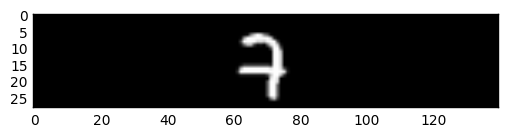

The label of this image from training set is [10 10  7 10 10]


In [20]:
# Pick a random image from the validation set
random_id = np.random.randint(len(multiMNIST_valid_dataset))
# Plot the image
fig = plt.figure()
plotwindow = fig.add_subplot(111)
plt.imshow(multiMNIST_valid_dataset[random_id], cmap='gray')
plt.show()
# Print the label of the image
print('The label of this image from training set is %s' %multiMNIST_valid_labels[random_id])

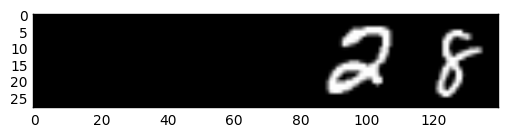

The label of this image from training set is [10 10 10  2  8]


In [21]:
# Pick a random image from the test set
random_id = np.random.randint(len(multiMNIST_test_dataset))
# Plot the image
fig = plt.figure()
plotwindow = fig.add_subplot(111)
plt.imshow(multiMNIST_test_dataset[random_id], cmap='gray')
plt.show()
# Print the label of the image
print('The label of this image from training set is %s' %multiMNIST_test_labels[random_id])

### Save multiMNIST_continuous dataset

In [22]:
# Save all the data and labels to single pickle file
multiMNIST_folder = 'data/multiMNIST/'
pickle_file = 'multiMNIST_continuous_' + str(size_synthesis) + '.pickle'
if os.path.exists(multiMNIST_folder + pickle_file):
    print('%s already present - Skipping pickling.' %pickle_file)
else:
    if not os.path.exists(multiMNIST_folder):
        os.makedirs(multiMNIST_folder)
    try:
        f = open(multiMNIST_folder + pickle_file, 'wb')
        save = {
            'train_dataset': multiMNIST_train_dataset,
            'train_labels': multiMNIST_train_labels,
            'valid_dataset': multiMNIST_valid_dataset,
            'valid_labels': multiMNIST_valid_labels,
            'test_dataset': multiMNIST_test_dataset,
            'test_labels': multiMNIST_test_labels,
        }
        pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
        f.close()
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

multiMNIST_continuous_80000.pickle already present - Skipping pickling.


### Summary: show 10 random synthetic multiMNIST_continuous dataset images

In [23]:
# Read data from multiMNIST.pickle
multiMNIST_folder = 'data/multiMNIST/'
pickle_file = 'multiMNIST_continuous_80000.pickle'

with open(multiMNIST_folder + pickle_file, 'rb') as f:
    print('Loading multiMNIST data ...')
    print('This may consume a lot of memories.')
    save = pickle.load(f)
    multiMNIST_train_dataset = save['train_dataset']
    multiMNIST_train_labels = save['train_labels']
    multiMNIST_valid_dataset = save['valid_dataset']
    multiMNIST_valid_labels = save['valid_labels']
    multiMNIST_test_dataset = save['test_dataset']
    multiMNIST_test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('multiMNIST training set', multiMNIST_train_dataset.shape, multiMNIST_train_labels.shape)
    print('multiMNIST validation set', multiMNIST_valid_dataset.shape, multiMNIST_valid_labels.shape)
    print('multiMNIST test set', multiMNIST_test_dataset.shape, multiMNIST_test_labels.shape)

Loading multiMNIST data ...
This may consume a lot of memories.
('multiMNIST training set', (64000, 28, 140), (64000, 5))
('multiMNIST validation set', (8000, 28, 140), (8000, 5))
('multiMNIST test set', (8000, 28, 140), (8000, 5))


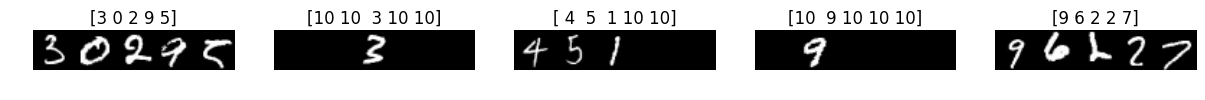

In [24]:
num_subplots = 5
dataset = multiMNIST_train_dataset
labels = multiMNIST_train_labels
fig, axes = plt.subplots(nrows = 1, ncols = num_subplots, figsize = (15, 5))
for i in xrange(num_subplots):
    axes[i].axis('off')
    random_id = np.random.randint(len(dataset))
    axes[i].imshow(dataset[random_id], cmap='gray')
    axes[i].set_title(labels[random_id], loc='center')

report_folder = 'report/'
if not os.path.exists(report_folder):
    os.makedirs(report_folder)
fig.savefig(report_folder + 'multiMNIST_continuous.jpeg', format = 'jpeg', dpi = 300, bbox_inches = 'tight')